## Modelling Notebook: Hidden Markov

In this notebook we build hidden markov models to try and predict fog states.

Given fog state data from the training set (2011 to 2019 inclusive) we formulate the model like so:

- The hidden state variable is **target_hr1**, the fog state 1 hour from now.
- If the emissions variable is visibility, **we are assuming that for any given time point, the fog state in an hour determines the visibility at this current time point.**
- HMM finds the sequence of target_hr1 states that maximise the probability of the emissions variable sequence.


In [1]:
# data processing
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from scipy import stats

# modelling
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from scipy.stats import uniform, randint

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# other
from tqdm import tqdm
import pickle
import os
import sys
seed=42

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# importing data and helper functions from directories dependent on which is available

joseph_path = '/content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/' # Joseph
julita_path = '/content/drive/My Drive/CA4021 (Final Year Project)/' # Julita

if os.path.exists(joseph_path):
  print("Importing from DS_Modules/CA4021")
  sys.path.append(os.path.join(joseph_path, 'scripts'))
  path = joseph_path

elif os.path.exists(julita_path):
  print("Importing directly from CA4021 folder")
  sys.path.append(sys.path.append(os.path.join(julita_path, 'scripts')))
  path = julita_path

Importing from DS_Modules/CA4021


In [4]:
# import helper functions from aux file (prevents too much function definitions in the notebook)
from aux_functions import missing_percentages, plot_dist_discrete, plot_dist_continuous, \
plot_vis_discrete, plot_vis_continuous, month_vplot

from aux_functions_ml import preprocess, manual_cross_validate, get_feat_importance_df, \
performance_report, calc_mean_importance, plot_importance, heidke_skill_score, score_model, display_scores

In [5]:
# import train/valid and test sets
df_train = pd.read_csv(os.path.join(path, 'data/train_data.csv'))
df_train.index=pd.to_datetime(df_train.date_time)
df_train.date_time = df_train.index

df_test = pd.read_csv(os.path.join(path, 'data/test_data.csv'))
df_test.index=pd.to_datetime(df_test.date_time)
df_test.date_time = df_test.index

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("Train/valid:", df_train.shape)
print("Test:", df_test.shape)

Train/valid: (78888, 57)
Test: (17544, 57)


In [6]:
df_train.head()

,date_time,year,month,day,hour,date,dir,speed,vis,ww,w,pchar,ptend,cbl,msl,drybulb,wetbulb,dewpt,vp,rh,clow,cmedium,chigh,nlc,ntot,hlc,nsig1,tsig1,hsig1,nsig2,tsig2,hsig2,nsig3,tsig3,hsig3,nsig4,tsig4,hsig4,ceiling,dos,weather,duration,rainfall,sunshine,tabdir,tabspeed,pweather,dni,vis_hr1,target_hr1,fog_state,season,temp_dew_dist,rainfall12hma,fog_formation,fog_dissipation,transition
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,2011,1,1,0,01-Jan-2011 00:00:00,27,7,9000,10,22,5,0.1,1017.1,1027.8,5.5,4.6,3.3,7.8,86,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,26,6,0,0,9000.0,0,no fog,winter,2.2,0.0,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,2011,1,1,1,01-Jan-2011 01:00:00,28,6,9000,10,22,5,0.0,1017.1,1027.8,5.1,4.4,3.4,7.8,89,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,28,6,0,0,8000.0,0,no fog,winter,1.7,0.0,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,2011,1,1,2,01-Jan-2011 02:00:00,27,6,8000,10,22,8,0.2,1016.8,1027.5,5.3,4.0,2.1,7.1,80,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,27,7,0,0,8000.0,0,no fog,winter,3.2,0.0,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,2011,1,1,3,01-Jan-2011 03:00:00,25,7,8000,10,22,7,0.5,1016.6,1027.3,5.2,4.6,3.7,8.0,90,5.0,0.0,0.0,7,7,23,7,6,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,27,7,0,0,8000.0,0,no fog,winter,1.5,0.0,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,2011,1,1,4,01-Jan-2011 04:00:00,28,7,8000,10,22,6,0.5,1016.6,1027.3,5.1,4.7,4.1,8.2,94,5.0,0.0,0.0,7,7,24,7,6,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,0.0,0,0.0,0.0,0.0,27,7,0,0,9000.0,0,no fog,winter,1.0,0.0,0,0,0


In [7]:
# LEAVING OUT w, ww, pweather and weather because of OH encoding sparsity

metadata = ['date', 'date_time', 'year', 'month', 'day', 'hour', 'season']
indicator = [col for col in df_train.columns if col[0] == 'i']
constant = [var for var in df_train.columns if len(df_train[var].value_counts()) == 1]
codes = ['sp1', 'sp2', 'sp3', 'sp4', 'wwa', 'wa', 'w' ,'ww', 'pweather', 'weather']
excluded = indicator + constant + codes + ['rgauge', 'sog', 'tabspeed', 'msl']
vis_vars=['target_hr1', 'vis_hr1', 'fog_formation', 'fog_dissipation', 'transition']
target = 'target_hr1'

categorical=['fog_state', 'season', 'tsig1', 'tsig2', 'tsig3', 'pchar'] #'w', 'ww', 'pweather',
             #'weather']
discrete = [var for var in df_train.columns if len(df_train[var].unique()) < 15 and 
             var not in excluded + categorical + metadata + codes + indicator + vis_vars]

continuous = [var for var in df_train.columns if var not in discrete + excluded + categorical + metadata + codes + indicator + vis_vars]
numerical = discrete+continuous
# conservative list of variables known to have an impact on fog formation.
# the other lists are too big for certain visualisations
fog_vars = ['rainfall', 'drybulb', 'cbl', 'ntot', 'dni', 'dewpt', 'speed', 'dir', 'rh']

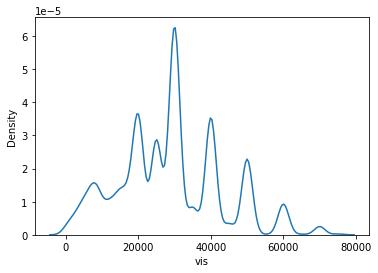

In [9]:
sns.kdeplot(df_train.vis)
plt.show()

In [11]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.2/217.2 KB 7.0 MB/s eta 0:00:00


In [17]:
from hmmlearn.hmm import GaussianHMM, GMMHMM

In [52]:
vis_arr = np.array(df_train.vis).reshape(-1, 1)

In the HMM implementation with continuous emissions variable, we must either use a gaussian or gaussian mixture HMM. We can set the number of states (2, fog and no fog), the starting probabilities of the states, and a transition probability between the states, but the model can't observe the states themselves during fitting.

We train the model using only observations from the emission variable (for the univariate model, just visibility).

In [78]:
# transition probability matrix obtained from persistence analysis
transition_matrix = np.array([[0.997345400959418, 0.0026545990405819216],
                             [0.339572192513369, 0.66042780748663]])

# mean values of emission variable for each state
mean_matrix = np.array([[vis_arr[vis_arr > 1000].mean()], 
                       [vis_arr[vis_arr <= 1000].mean()]])

In [80]:
n_models = 1
scores = []
models = []
for i in range(n_models):
  model = GaussianHMM(n_components=2, random_state=seed, n_iter=100, init_params='c')
  
  # initialise the
  model.startprob = np.array([1, 0])
  model.transmat = transition_matrix
  model.means = mean_matrix

  # set the starting transition probabilities
  model.fit(vis_arr)
  models.append(model)
  scores.append(model.score(vis_arr))
  print(f'Converged: {model.monitor_.converged}\t\t'
              f'Score: {scores[-1]}')


# get the best model
model = models[np.argmax(scores)]
print(f'The best model had a score of {max(scores)}')

# use the Viterbi algorithm to predict the most likely sequence of states
# given the model
states = model.predict(vis_arr)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Converged: True		Score: -841957.2861381902
The best model had a score of -841957.2861381902


In [81]:
model.means_

array([[39095.85594311],
       [17744.44359275]])

In [82]:
Counter(states)

Counter({1: 37929, 0: 40959})

Text(0.5, 0, 'State')

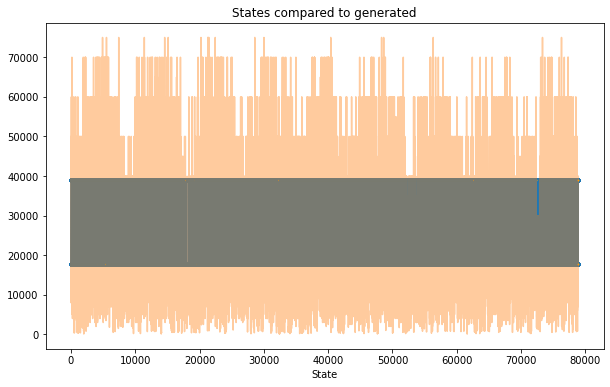

In [83]:
# plot model states over time
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(model.means_[states], ".-", ms=6, mfc="orange")
ax.plot(vis, alpha=0.4)
ax.set_title('States compared to generated')
ax.set_xlabel('State')

The following reasons contribute to the model failure.
:
1. The assumptions of hidden markov are broken when we try to predict fog this way. The hidden state variable we're predicting (fog in an hour) actually occurs after the observed emission varibale (visibility right now), so it's impossible for the hidden state to impact the emmission.

2. Since we have a continuous emissions variable we use a gaussian HMM model. This asssumes that the two hidden states generate the emissions data according to two separate Normal Distributions. Our emission variable, visibility, is continuous in some ranges, and discrete in other ranges,.

3. The hidden state "fog state" isn't really hidden, so when we model it as a hidden state we get state distributions that disagree with the real state distributions that we observe. I.e. the state predictions don't correspond to fog states.

HMM is not suited to predicting just 1 future state, but rather decoding an entire sequence of states given a sequence of emissions which isn't our goal. Since we have the state information available directly, a regular markov model is better for predicting the next state, and based on the persistence analysis, the best markov model for predicting fog state is just the previous state as the current state prediction.